In [1]:
import diffrax
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt

from pde_opt.numerics.domains import Domain
from pde_opt.numerics.equations.gross_pitaevskii import GPE2DTSControl
from pde_opt.numerics.solvers import StrangSplitting
from pde_opt.numerics.utils.initialization_utils import initialize_Psi, add_vortex_to_wavefunction

In [2]:
def density(psi):
    return jnp.abs(psi)**2

In [3]:
# Get variables with dimensions
atoms = 5e5
hbar = 1.05e-34 #J*s
omega = 2*jnp.pi*10 #1/s
omega_z = jnp.sqrt(8)*omega
epsilon = 0.0
mass = 3.8175406e-26 #kg (atomic mass of sodium-23)
a0 = 5.29177210903e-11
a_s = 100*a0
N = 256

x_s = jnp.sqrt(hbar/(mass*omega))
t_s = 1/omega

# Length of the x and y axes in meters
Lx = 150e-6 #meters
Ly = 150e-6 #meters

# Get dimensionless variables
Lx_ = Lx/x_s
Ly_ = Ly/x_s

# Get k
k = 4*jnp.pi*a_s*atoms*jnp.sqrt((mass*omega_z)/(2*jnp.pi*hbar))

epsilon = 0.0

t_start = 0.0
t_final = 0.1
dt = 1e-5

t_start_ = t_start/t_s
t_final_ = t_final/t_s
dt_ = dt/t_s

domain_ = Domain((N,N,), ((-Lx_/2, Lx_/2), (-Ly_/2, Ly_/2),), "dimensionless")

In [4]:
Psi0 = initialize_Psi(N, width=100, vortexnumber=0)
Psi0_ = Psi0*x_s
Psi0_ /= jnp.sqrt(jnp.sum(density(Psi0_))*domain_.dx[0]**2)

In [5]:
eq = GPE2DTSControl(domain_, k, epsilon, lambda a,b,c: 0.0, trap_factor=1.0)

solver = StrangSplitting(eq.A_term, eq.domain.dx[0], eq.fft, eq.ifft, -1j)


In [6]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.B_terms(y, t))),
    solver,
    t0=t_start_,
    t1=t_final_,
    dt0=dt_,
    y0=jnp.stack([Psi0_.real, Psi0_.imag], axis=-1),
    # stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6),
    saveat=diffrax.SaveAt(ts=jnp.linspace(t_start_, t_final_, 100)),
    max_steps=1000000,
)

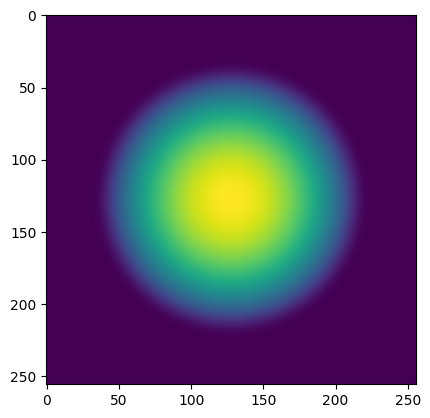

In [8]:
plt.imshow(density(solution.ys[-1][...,0] + 1j*solution.ys[-1][...,1]))

In [ ]:
def tf_mu_2d(N, g, omegax, omegay):
    # 2D TF with elliptical parabola: N = (pi/(g)) * (mu^2)/(0.5 omegax omegay)
    # => mu = sqrt( (N g 0.5 omegax omegay)/pi )
    mu = jnp.sqrt((N * g * 0.5 * omegax * omegay) / jnp.pi)
    return mu

def tf_density_2d(X, Y, N, g, omegax, omegay):
    mu = tf_mu_2d(N, g, omegax, omegay)
    V = 0.5 * (omegax**2 * X**2 + omegay**2 * Y**2)
    n = (mu - V) / g
    return jnp.clip(n, a_min=0.0, a_max=None), mu